# Miniproject - Neuroscience: cellular and circuit mechanisms (BIO-482)

- This notebook produces the figures for **part 1** of the miniproject.

#### Importing libraries

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import scipy.stats
#%matplotlib widget
import matplotlib.pyplot as plt
import seaborn as sns

#### Importing helper functions
 Feel free to check out what these functions do in the corresponding files, `helpers.py` or `utils.py`. 
 - `helpers.py` contains functions to analyze membrane potential recording data
 - `utils.py` contains functions useful for other things e.g. plotting

In [3]:
base_path = os.getcwd()
base_path = base_path.replace('notebooks', 'scripts') # note: if you have notebooks twice in your base_path, this won't work
sys.path.insert(1, base_path)

from helpers import *
from utils import remove_top_right_frame, jitter_scatterplot

# Test

In [4]:
os.getcwd()

'/home/lena/Documents/MA3/neuro/BIO482_MiniProject_2023_Python/notebooks'

# Load data
Load the data as `.pkl` file (saved from MATLAB):

In [5]:
# Make paths
main_dir = r'/home/lena/Documents/MA3/neuro/BIO482_MiniProject_2023_Python/' # EDIT the path !!!!!!!
print('Main working directory:', main_dir)
figure_path = os.path.join(main_dir, 'Figures')
os.makedirs(figure_path, exist_ok=True)
data_path = os.path.join(main_dir, 'Data') #if your folder is organized differently, just specify the full path to the .mat file
data_path = '../Data/'

fname = 'data_bio482-001.pkl'
data_df = pd.read_pickle(os.path.join(data_path, fname))

Main working directory: /home/lena/Documents/MA3/neuro/BIO482_MiniProject_2023_Python/


**Save the dataframe for later use:**

Inspect how the dataframe looks like:

In [6]:
data_df['Sweep_Type'].unique()

array(['active touch', 'passive contact', 'free whisking'], dtype=object)

In [7]:
data_df.describe() #shows numeric columns only

,Cell_APThreshold_Slope,Cell_Counter,Cell_Depth,Mouse_DateOfBirth,Sweep_Counter,Sweep_MembranePotential_SamplingRate,Sweep_StartTime,Sweep_WhiskerAngle_SamplingRate
count,831.000000,831.000000,814.000000,602.000000,831.000000,831.0,831.000000,831.0
mean,15.330927,1.450060,296.168305,2015.315615,3.669073,20000.0,2013.281588,100.0
std,7.035538,0.780545,140.527726,0.713587,3.605550,0.0,3.761586,0.0
min,0.000000,1.000000,97.000000,2013.000000,1.000000,20000.0,2005.000000,100.0
25%,10.000000,1.000000,185.000000,2015.000000,1.000000,20000.0,2013.000000,100.0
50%,15.000000,1.000000,234.000000,2015.000000,3.000000,20000.0,2015.000000,100.0
75%,20.000000,2.000000,427.000000,2016.000000,4.000000,20000.0,2016.000000,100.0
max,40.000000,5.000000,665.000000,2017.000000,27.000000,20000.0,2017.000000,100.0


# Part 1 - Properties of cortical neurons during quiet wakefulness: suprathreshold/subthreshold activity and cell class [3/10 marks]

Set general general parameters that we will use throughout part 1:

In [8]:
sweep_type = 'active touch'
time_window = 2    # time window to analyze Vm (s)
freq_band_lim = [1, 10, 30, 90] # low- and high-frequency band limits (Hz)

 Select data for specific one sweep type (sweep and trial are synonymous):

In [9]:
data_df_subset = data_df[data_df['Sweep_Type']==sweep_type] 

Find all the unique recorded cells present in the data:

Done!


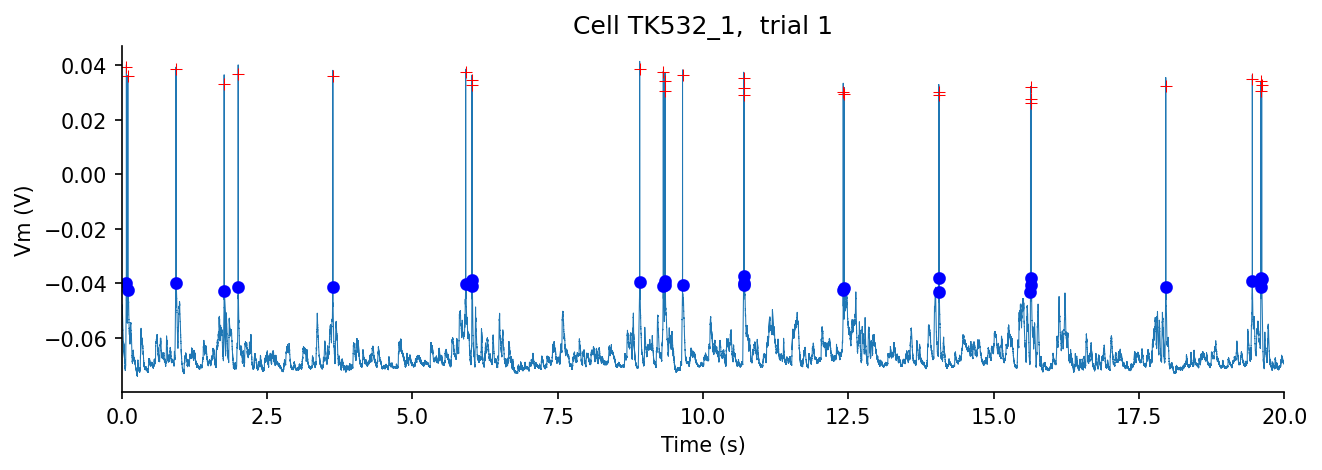

In [13]:
# Analyse and plot one sweep for one neuron

cell_list = sorted(np.unique(data_df_subset.Cell_ID), reverse=True) #NOTE: DO NOT START WITH AC32 bc. no AP and undefined ap_params content

# choose 1 cell
cell=cell_list[5];

# Get data subset for that cell
cell_df = data_df_subset[data_df_subset.Cell_ID==cell]

# Get sweeps/trials recorded for that cell, that we are going to iterate over
trial_list = cell_df.Sweep_Counter.values
trial=trial_list[0]
# Get current trial data
cell_trial_df = cell_df[cell_df.Sweep_Counter==trial]

# Get the sampling rate and membrane potential (and derivative) from that sweep
        
sr_vm = cell_trial_df['Sweep_MembranePotential_SamplingRate'].values[0] #[0] to get the content of the array
membrane_potential = cell_trial_df['Sweep_MembranePotential'].values[0]
ap_vm_deriv_thresh = cell_trial_df['Cell_APThreshold_Slope'].values[0]
        
# Get and update recording duration for that cell by adding trial duration
trial_rec_duration = len(membrane_potential)/sr_vm
#tot_rec_duration += trial_rec_duration
        
# Detection of action potentials for that trial, and update total number of APs for that cell
#ap_params = None
ap_params = Function_Detect_APs(membrane_potential, sr_vm, ap_vm_deriv_thresh) 
#tot_number_ap += ap_params.shape[0]
          
# Check if this trial contains any AP...
ap_duration = []

if (ap_params.any()):
    ap_thresh_times = ap_params[:,0]
    ap_thresh_vm = ap_params[:,1]
    ap_peak_times = ap_params[:,2]
    ap_peak_vm = ap_params[:,3]
    ap_duration = ap_params[:,5] #check for no-APs (cells with no spikes in ALL trials:EXC5,16 FR=0, AP_dur=np.nan)

    #... if so, cut-out individual APs to keep subthreshold Vm only
    vm_sub = Function_CutAPs(membrane_potential, sr_vm, ap_peak_times, ap_thresh_times)
            
     # Else if no AP, subthreshold Vm is just Vm
else:
            
         vm_sub = membrane_potential.copy()
            
# Optional plotting: show AP and AP peak times

time=[];
for i in range(0, len(membrane_potential)):
    time.append(i/sr_vm)

ap_peak_index=np.round(ap_peak_times * sr_vm)
ap_thresh_index=np.round(ap_thresh_times * sr_vm)

fig, ax = plt.subplots(1,1, figsize=(10,3), dpi=150)
remove_top_right_frame(ax)
ax.set_title('Cell {},  trial {}'.format(cell, int(trial)))
ax.plot(time, membrane_potential, lw=0.5,  zorder=0)
ax.scatter(ap_peak_times, ap_peak_vm, lw=0.5, marker='+', color='r')
ax.scatter(ap_thresh_times, ap_thresh_vm, lw=0.1, marker='o', color='b')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Vm (V)')
plt.xlim([0, 20])

# Save figure
fname = os.path.join(figure_path, '0_Example_Cell.png')
plt.savefig(fname=fname, dpi='figure', format='png', bbox_inches='tight')


print('Done!')


# Here we start the analysis
- Here, we iterate over cells and trials per cell to compute, collect relevant data.

In [14]:
all_cells = np.unique(data_df_subset.Cell_ID)
print('Number of cells:', len(all_cells))

Number of cells: 134


In [15]:
all_cells

array(['JP902_1', 'JP903_1', 'JP905_1', 'JP906_1', 'JP907_1', 'SC901_1',
       'SC903_1', 'SC904_1', 'SC905_1', 'SC906_1', 'SC907_1', 'SC908_1',
       'SC909_1', 'SC910_1', 'SC911_1', 'SC912_1', 'SC913_1', 'SC914_1',
       'SC915_1', 'SC916_1', 'SC917_1', 'SC918_1', 'SC919_1', 'SC923_1',
       'SC924_1', 'SC925_1', 'SC926_1', 'TK177_1', 'TK318_1', 'TK320_1',
       'TK320_2', 'TK323_1', 'TK326_2', 'TK333_1', 'TK334_1', 'TK348_1',
       'TK353_1', 'TK355_1', 'TK358_2', 'TK358_3', 'TK364_1', 'TK367_1',
       'TK373_1', 'TK376_1', 'TK383_1', 'TK384_2', 'TK385_1', 'TK385_2',
       'TK387_1', 'TK390_1', 'TK402_1', 'TK403_1', 'TK407_1', 'TK408_1',
       'TK409_1', 'TK412_1', 'TK414_1', 'TK414_2', 'TK415_1', 'TK415_2',
       'TK415_3', 'TK416_1', 'TK416_2', 'TK450_1', 'TK454_1', 'TK455_1',
       'TK455_2', 'TK457_1', 'TK461_1', 'TK462_1', 'TK462_2', 'TK462_3',
       'TK463_1', 'TK468_1', 'TK470_1', 'TK470_2', 'TK471_1', 'TK472_1',
       'TK473_1', 'TK478_1', 'TK479_1', 'TK479_2', 

In [16]:
verbose=False #set to 0 to hide individual AP plots

# Initialize a dictionary to store data for all cell
result_dict = {'cell_id': all_cells, 
          'cell_type':[], # required for cell-type identification
          # Data we'll collect for Part 1a
          'firing_rate': [], 
          'ap_threshold': [], 
          'ap_duration': [], 
          # Data we'll collect for Part 1b
          'mean_vm':[],
          'std_vm':[],
          'fft_low':[],
          'fft_high':[]
        }

result_fft_cell_type = {'EXC':[],'SST':[], 'VIP':[],'PV':[]}

exc_cell_counter = 0

# Iterate over each cell identities to collect desired data
cell_list = sorted(np.unique(data_df_subset.Cell_ID), reverse=True) #NOTE: DO NOT START WITH AC32 bc. no AP and undefined ap_params content
for idx, cell in enumerate(cell_list):
    if idx%100==0:
        print('Cell {}/{}'.format(idx, np.unique(data_df_subset.Cell_ID).shape[0]))
    
    # Get mouse name and cell number from cell identifier
    mouse = cell.split('_')[0]
    cell_count = float(cell.split('_')[1])
    
    # Get data subset for that cell
    cell_df = data_df_subset[data_df_subset.Cell_ID==cell]
    
    # Get cell type 
    cell_type = cell_df.Cell_Type.values[0]
    result_dict['cell_type'] += [cell_type]
    
    # Get sweeps/trials recorded for that cell, that we are going to iterate over
    trial_list = cell_df.Sweep_Counter.values
    
    # Init. cell recording specific quantities: a unique duration, yielding a unique number of APs
    tot_rec_duration = 0
    tot_number_ap = 0
    
    # Initialize empty lists to get data for each trial/sweep
    # Part 1a
    tot_ap_thresh = []
    tot_ap_duration = []
    # Part 1b
    tot_mean_vm = []
    tot_std_vm = []
    tot_fft = []
    
    # For that cell, iterate over trials
    for trial in trial_list:
        #if idx % 100 == 0: # print every 100 iteration  
            #print('Cell {},  trial {}'.format(cell, int(trial)))
        if cell_type == 'EXC':
            exc_cell_counter += 1
        
        # Get current trial data
        cell_trial_df = cell_df[cell_df.Sweep_Counter==trial]
        
        # Get the sampling rate and membrane potential (and derivative) from that sweep
        sr_vm = cell_trial_df['Sweep_MembranePotential_SamplingRate'].values[0] #[0] to get the content of the array
        membrane_potential = cell_trial_df['Sweep_MembranePotential'].values[0]
        ap_vm_deriv_thresh = cell_trial_df['Cell_APThreshold_Slope'].values[0]
        
        # Get and update recording duration for that cell by adding trial duration
        trial_rec_duration = len(membrane_potential)/sr_vm
        tot_rec_duration += trial_rec_duration
        
        # Detection of action potentials for that trial, and update total number of APs for that cell
        #ap_params = None
        ap_params = Function_Detect_APs(membrane_potential, sr_vm, ap_vm_deriv_thresh) 
        tot_number_ap += ap_params.shape[0]
          
        # Check if this trial contains any AP...
        ap_duration = []
        if (ap_params.any()):
            ap_thresh_times = ap_params[:,0]
            ap_thresh_vm = ap_params[:,1]
            ap_peak_times = ap_params[:,2]
            ap_peak_vm = ap_params[:,3]
            ap_duration = ap_params[:,5] #check for no-APs (cells with no spikes in ALL trials:EXC5,16 FR=0, AP_dur=np.nan)

            #... if so, cut-out individual APs to keep subthreshold Vm only
            vm_sub = Function_CutAPs(membrane_potential, sr_vm, ap_peak_times, ap_thresh_times)
            
            
        # Else if no AP, subthreshold Vm is just Vm
        else:
            
            vm_sub = membrane_potential.copy()

        # Once Vm_sub is obtained:
        # Compute subthreshold Vm mean and standard deviation
        mean_vm, std_vm = Function_SubThrsVm(vm_sub, sr_vm, trial_rec_duration)
        
        # Compute trial FFT
        fft = Function_Compute_FFTs(vm_sub, sr_vm, time_window)
        
        #Update current variables from the current trial
        # Part 1a
        tot_ap_thresh += [np.concatenate([ap_thresh_vm])]
        tot_ap_duration += [ap_duration]
        # Part 1b
        tot_mean_vm += [mean_vm]
        tot_std_vm += [std_vm]
        tot_fft +=  [fft]
        
        # Optional plotting: show AP and AP peak times
        ap_peak_index=np.round(ap_peak_times * sr_vm)  
        if verbose:
            fig, ax = plt.subplots(1,1, figsize=(10,2), dpi=300)
            remove_top_right_frame(ax)
            ax.set_title('Cell {},  trial {}'.format(cell, int(trial)))
            ax.plot(membrane_potential, lw=0.5,  zorder=0)
            ax.scatter(ap_peak_index, ap_peak_vm, lw=0.5, marker='+', color='r')
            ax.set_xlabel('Time (samples)')
            ax.set_ylabel('Membrane \n potential (V)')
            plt.show()

    # Once iterated over all trials for that cell, append cell data lists to the result dictionary
  
    # Part 1a
    result_dict['firing_rate'] += [tot_number_ap / tot_rec_duration] # <- just the firing rate formula
    result_dict['ap_threshold'] += [np.nanmean(np.concatenate(tot_ap_thresh))] #<-concatenate trials, get trial-average
    result_dict['ap_duration'] += [np.nanmean(np.concatenate(tot_ap_duration))]

    
    # Part 1b
    result_dict['mean_vm'] += [np.nanmean(np.concatenate(tot_mean_vm))]
    result_dict['std_vm'] += [np.nanmean(np.concatenate(tot_std_vm))]
    
    # Compute mean FFT over trials
    tot_fft = np.nanmean(np.concatenate(tot_fft, axis=1), 1)
    #Store mean cell FFT
    result_fft_cell_type[cell_type] += [tot_fft] 
    
    # We need to find which point (sample) in the FFT correspond to which frequency
    pt1 = int(freq_band_lim[0] * fft.shape[0] / (sr_vm/2) ) + 1 #1Hz into FFT point
    pt2 = int(freq_band_lim[1] * fft.shape[0] / (sr_vm/2) ) + 1 #int: slicing requires integers
    result_dict['fft_low'] += [tot_fft[pt1:pt2].mean()]
    
    pt3 = int(freq_band_lim[2] * fft.shape[0] / (sr_vm/2) ) + 1
    pt4 = int(freq_band_lim[3] * fft.shape[0] / (sr_vm/2) ) + 1 
    result_dict['fft_high'] += [tot_fft[pt3:pt4].mean()]

## Convert each dictionary lists as numpy arrays (convenient to make dataframes)
result_dict = {key: np.array(result_dict[key]) for key in result_dict.keys()}

print('Done!')

Cell 0/134


/home/lena/Documents/MA3/neuro/BIO482_MiniProject_2023_Python/scripts/helpers.py:18: RuntimeWarning: invalid value encountered in divide
  AP_Thrs_Onset = np.diff(np.divide(Vm_Deriv - Vm_Deriv_Thrs, np.abs(Vm_Deriv - Vm_Deriv_Thrs)))


Cell 100/134


/home/lena/Documents/MA3/neuro/BIO482_MiniProject_2023_Python/scripts/helpers.py:52: RuntimeWarning: invalid value encountered in divide
  sAP_OnOff = np.diff(np.divide(sAP_Seg, np.abs(sAP_Seg)))  # compute the binary signal
/tmp/ipykernel_3360/4015871802.py:129: RuntimeWarning: Mean of empty slice
  result_dict['ap_duration'] += [np.nanmean(np.concatenate(tot_ap_duration))]


Done!


Format result dictionary as dataframe:

In [17]:
result_df = pd.DataFrame(result_dict)
result_df.head(5)

,cell_id,cell_type,firing_rate,ap_threshold,ap_duration,mean_vm,std_vm,fft_low,fft_high
0,JP902_1,EXC,1.062500,-0.038696,0.670588,-0.061195,0.006330,0.000880,0.000066
1,JP903_1,EXC,1.750000,-0.039856,1.126786,-0.054889,0.004605,0.000627,0.000092
2,JP905_1,EXC,1.391667,-0.036766,0.802096,-0.058734,0.005968,0.000710,0.000054
3,JP906_1,EXC,1.066667,-0.031500,0.993750,-0.053566,0.006013,0.000757,0.000073
4,JP907_1,EXC,0.600000,-0.040162,0.841667,-0.059964,0.004342,0.000476,0.000054


In [18]:
new_col = (result_df['cell_type'])[::-1].reset_index(drop=True)
new_col

0      EXC
1      EXC
2      EXC
3      EXC
4      EXC
      ... 
129    EXC
130    EXC
131    EXC
132    EXC
133    EXC
Name: cell_type, Length: 134, dtype: object

In [19]:
i

579999

In [20]:
result_df['cell_type'] = new_col
result_df['cell_type']

0      EXC
1      EXC
2      EXC
3      EXC
4      EXC
      ... 
129    EXC
130    EXC
131    EXC
132    EXC
133    EXC
Name: cell_type, Length: 134, dtype: object

In [21]:
result_df.to_csv('df_1_act.csv')

## Inspect and compute statistics per cell type
We have a now a dictionary with different data for each cell. The `pd.DataFrame` function `describe()` provides summary statistics over the entire dataframe.

In [13]:
result_df.describe()

,firing_rate,ap_threshold,ap_duration,mean_vm,std_vm,fft_low,fft_high
count,232.000000,232.000000,230.000000,232.000000,232.000000,232.000000,232.000000
mean,10.290598,-0.040782,0.816558,-0.054247,0.005126,0.000643,0.000063
std,15.298162,0.003362,0.512842,0.005861,0.001553,0.000224,0.000023
min,0.000000,-0.048334,0.223307,-0.069672,0.001333,0.000153,0.000019
25%,1.133373,-0.042997,0.471269,-0.057528,0.003940,0.000479,0.000044
50%,4.270151,-0.040938,0.688999,-0.053780,0.005044,0.000629,0.000058
75%,14.412500,-0.039056,0.999929,-0.050454,0.006072,0.000779,0.000077
max,127.119565,-0.028422,3.397441,-0.038174,0.010206,0.001389,0.000130


We can also inspect per cell type, given that we included this information in `result`. Note that we can also group and show statistics using other categories.

In [14]:
pd.set_option('display.max_columns', None) #this is just to print all columns
result_df.groupby('cell_type').describe()

firing_rate                                                        \
                count       mean        std       min        25%        50%   
cell_type                                                                     
EXC              86.0   1.822587   2.297689  0.000000   0.320833   0.862500   
PV               49.0  29.342716  21.820534  2.083333  16.486486  27.152174   
SST              72.0   6.597306   6.314112  0.382353   2.354167   4.464943   
VIP              25.0  12.715087  10.889318  0.005208   5.643333   7.483333   

                                 ap_threshold                                \
                 75%         max        count      mean       std       min   
cell_type                                                                     
EXC         2.766532   11.658333         86.0 -0.039852  0.003536 -0.046335   
PV         34.833333  127.119565         49.0 -0.041382  0.002356 -0.045868   
SST         7.801087   30.384615         72.0 -0.041758  0.003160 -0.048334   
VIP        18.683333   41.666667         25.0 -0.039990  0.004068 -0.045415   

                                                  ap_duration            \
                25%       50%       75%       max       count      mean   
cell_type                                                                 
EXC       -0.042038 -0.040294 -0.038210 -0.028422        84.0  1.191268   
PV        -0.043008 -0.041307 -0.039693 -0.034840        49.0  0.391629   
SST       -0.043603 -0.041913 -0.039583 -0.034625        72.0  0.638990   
VIP       -0.043794 -0.039914 -0.037786 -0.029834        25.0  0.901792   

                                                                      mean_vm  \
                std       min       25%       50%       75%       max   count   
cell_type                                                                       
EXC        0.564107  0.487500  0.849714  1.001195  1.448956  3.397441    86.0   
PV         0.126124  0.223307  0.313182  0.351986  0.429586  0.773966    49.0   
SST        0.294241  0.266624  0.471235  0.575937  0.705945  1.907738    72.0   
VIP        0.398551  0.523710  0.617245  0.802230  1.028795  2.451817    25.0   

                                                                       \
               mean       std       min       25%       50%       75%   
cell_type                                                               
EXC       -0.058215  0.005977 -0.069672 -0.062525 -0.058026 -0.054594   
PV        -0.052489  0.003800 -0.060553 -0.055180 -0.052712 -0.050498   
SST       -0.052026  0.004456 -0.063655 -0.055150 -0.051752 -0.048911   
VIP       -0.050439  0.004884 -0.058287 -0.053417 -0.052047 -0.047169   

                    std_vm                                                    \
                max  count      mean       std       min       25%       50%   
cell_type                                                                      
EXC       -0.038375   86.0  0.005337  0.001179  0.002618  0.004543  0.005329   
PV        -0.041178   49.0  0.006238  0.001519  0.003351  0.005151  0.006106   
SST       -0.043044   72.0  0.004017  0.000994  0.002298  0.003335  0.003736   
VIP       -0.038174   25.0  0.005411  0.002074  0.001333  0.004271  0.005675   

                              fft_low                                          \
                75%       max   count      mean       std       min       25%   
cell_type                                                                       
EXC        0.006050  0.008932    86.0  0.000687  0.000169  0.000331  0.000560   
PV         0.006926  0.009964    49.0  0.000804  0.000247  0.000381  0.000641   
SST        0.004577  0.006885    72.0  0.000481  0.000134  0.000285  0.000386   
VIP        0.006800  0.010206    25.0  0.000646  0.000259  0.000153  0.000512   

                                        fft_high                      \
                50%       75%       max    count      mean       std   
cell_type              

# Plots
Let's just define a dictionary for color coding cell classes, and a list to keep cell type order fixed:

In [15]:
class_color = {'EXC':'k',
               'PV':'indianred',
               'VIP':'royalblue',
               'SST':'darkorange'} 
cell_class_order = ['EXC', 'PV', 'VIP', 'SST']

## Compare mean firing rates across cells and cell types

The advantage of using `pd.DataFrame` is that we can use the library `seaborn`, which allow for fast and clear visualization. However, for more customized figures, seaborn sometimes makes things complicated. 

- However, for more customized figures, seaborn sometimes makes things complicated. 
- Here, we would like individual observations to be shifted relative to the errorbar, which we cannot easily do with seaborn. With matplotlib alone, we can do like this:

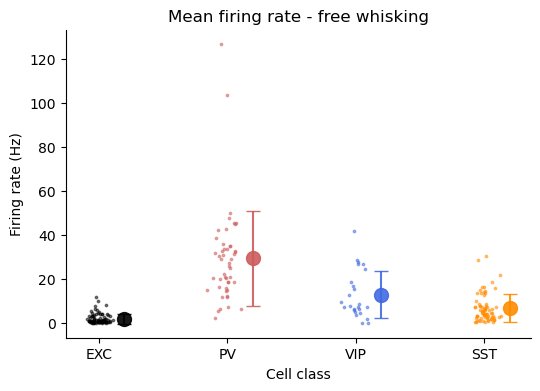

In [16]:
# Define figure
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4), dpi=100)
remove_top_right_frame(ax)

# Iterate over cell class
for i, c_type in enumerate(cell_class_order):
    
    n_cells = len(result_df[result_df.cell_type==c_type])
    obs_locations = [i]*n_cells #create a list int, to place observations categorically
    obs_values = result_df[result_df.cell_type==c_type]['firing_rate'].values
    
    # Show individual observations (scatterplot with added x-axis jitter to avoid overplotting)
    jitter_scatterplot(x=obs_locations, 
                       y=obs_values,
                       s=3, 
                       alpha=0.5, 
                       c=class_color[c_type])
    
    # Show mean and standard deviation
    ax.errorbar(x=i+0.2,
                 y=np.mean(obs_values),
                 yerr=np.std(obs_values), #errobarsize is standard deviation
                 marker='o', 
                 ms=10, 
                 capsize=5,
                 alpha=0.9, 
                 c=class_color[c_type])
    
# Set xtick labels and legend
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(cell_class_order)
ax.set_xlabel('Cell class')
ax.set_ylabel('Firing rate (Hz)')
ax.set_title('Mean firing rate - free whisking')

# Save figure
fname = os.path.join(figure_path, '1_Mean_Firing_Rate.png')
plt.savefig(fname=fname, dpi='figure', format='png', bbox_inches='tight')



In [17]:
# stats comparison between cell types (Tukey's HSD test)
from scipy.stats import tukey_hsd
Obs_EXC = result_df[result_df.cell_type=='EXC']['firing_rate'].values
Obs_PV = result_df[result_df.cell_type=='PV']['firing_rate'].values
Obs_VIP = result_df[result_df.cell_type=='VIP']['firing_rate'].values
Obs_SST = result_df[result_df.cell_type=='SST']['firing_rate'].values
    
Res=tukey_hsd(Obs_EXC, Obs_PV, Obs_VIP, Obs_SST)
print(Res)

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)    -27.520     0.000   -32.743   -22.298
 (0 - 2)    -10.892     0.000   -17.522    -4.263
 (0 - 3)     -4.775     0.042    -9.436    -0.114
 (1 - 0)     27.520     0.000    22.298    32.743
 (1 - 2)     16.628     0.000     9.456    23.799
 (1 - 3)     22.745     0.000    17.342    28.149
 (2 - 0)     10.892     0.000     4.263    17.522
 (2 - 1)    -16.628     0.000   -23.799    -9.456
 (2 - 3)      6.118     0.093    -0.656    12.891
 (3 - 0)      4.775     0.042     0.114     9.436
 (3 - 1)    -22.745     0.000   -28.149   -17.342
 (3 - 2)     -6.118     0.093   -12.891     0.656



## Compare mean action potential duration across cells and cell types

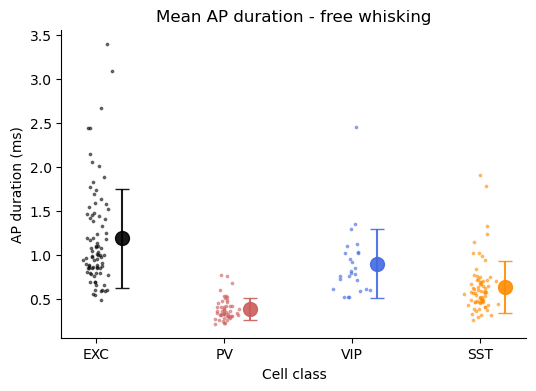

In [18]:
# Define figure
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4), dpi=100)
remove_top_right_frame(ax)

# Iterate over cell class
for i, c_type in enumerate(cell_class_order):
    
    n_cells = len(result_df[result_df.cell_type==c_type])
    obs_locations = [i]*n_cells #create a list int, to place observations categorically
    obs_values = result_df[result_df.cell_type==c_type]['ap_duration'].values
    
    # Show individual observations (scatterplot with added x-axis jitter to avoid overplotting)
    jitter_scatterplot(x=obs_locations, 
                       y=obs_values,
                       s=3, 
                       alpha=0.5, 
                       c=class_color[c_type])
    
    # Show mean and standard deviation
    ax.errorbar(x=i+0.2,
                 y=np.nanmean(obs_values),
                 yerr=np.nanstd(obs_values), #errobarsize is standard deviation
                 marker='o', 
                 ms=10, 
                 capsize=5, 
                 alpha=0.9, 
                 c=class_color[c_type])
    
# Set xtick labels and legend
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(cell_class_order)
ax.set_xlabel('Cell class')
ax.set_ylabel('AP duration (ms)')
ax.set_title('Mean AP duration - free whisking')
    
    
# Save figure
fname = os.path.join(figure_path, '2_Mean_AP_Duration.png')
plt.savefig(fname=fname, dpi='figure', format='png', bbox_inches='tight')
       


In [19]:
# stats comparison between cell types (Tukey's HSD test)
from scipy.stats import tukey_hsd
Obs_EXC = result_df[result_df.cell_type=='EXC']['ap_duration'].values
Obs_PV = result_df[result_df.cell_type=='PV']['ap_duration'].values
Obs_VIP = result_df[result_df.cell_type=='VIP']['ap_duration'].values
Obs_SST = result_df[result_df.cell_type=='SST']['ap_duration'].values

nan_ids = np.isnan(Obs_EXC)
Obs_EXC= Obs_EXC[~nan_ids]
nan_ids = np.isnan(Obs_PV)
Obs_PV= Obs_PV[~nan_ids]
nan_ids = np.isnan(Obs_VIP)
Obs_VIP= Obs_VIP[~nan_ids]
nan_ids = np.isnan(Obs_SST)
Obs_SST= Obs_SST[~nan_ids]
    
Res=tukey_hsd(Obs_EXC, Obs_PV, Obs_VIP, Obs_SST)
print(Res)

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.800     0.000     0.611     0.988
 (0 - 2)      0.289     0.010     0.050     0.529
 (0 - 3)      0.552     0.000     0.384     0.721
 (1 - 0)     -0.800     0.000    -0.988    -0.611
 (1 - 2)     -0.510     0.000    -0.768    -0.252
 (1 - 3)     -0.247     0.006    -0.442    -0.053
 (2 - 0)     -0.289     0.010    -0.529    -0.050
 (2 - 1)      0.510     0.000     0.252     0.768
 (2 - 3)      0.263     0.029     0.019     0.506
 (3 - 0)     -0.552     0.000    -0.721    -0.384
 (3 - 1)      0.247     0.006     0.053     0.442
 (3 - 2)     -0.263     0.029    -0.506    -0.019



## Compare mean firing rate with AP duration across cells and cell types

with seaborn:

/home/lena/miniconda3/envs/bio482/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lena/miniconda3/envs/bio482/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lena/miniconda3/envs/bio482/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lena/miniconda3/envs/bio482/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future v

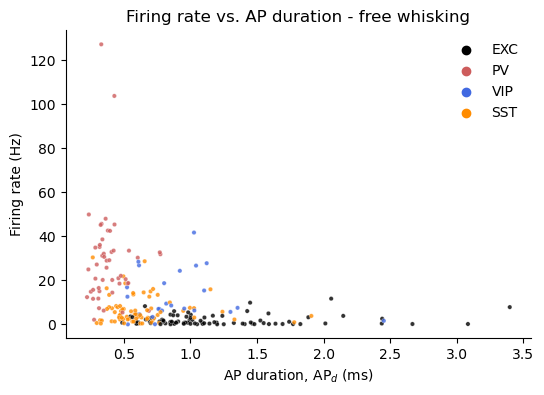

In [20]:
# Define figure
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4), dpi=100)
remove_top_right_frame(ax)

sns.scatterplot(data=result_df,
                ax=ax,
               x='ap_duration',
               y='firing_rate',
               hue='cell_type',
               hue_order=cell_class_order,
               palette=class_color,
               #ec=None,
                s=10,
               alpha=0.8)

# Axes
ax.set_xlabel('AP duration, AP$_d$ (ms)')
ax.set_ylabel('Firing rate (Hz)')
ax.set_title('Firing rate vs. AP duration - free whisking')
ax.legend(frameon=False)

We import a model class from `scikit-learn`, a standard machine learning library:

In [21]:
from sklearn.linear_model import LinearRegression 

/tmp/ipykernel_40995/3035054.py:8: RuntimeWarning: divide by zero encountered in log
  data_fr = np.log(result_df[result_df.cell_type==c_type]['firing_rate'].values)/np.log(10)
/tmp/ipykernel_40995/3035054.py:25: RuntimeWarning: divide by zero encountered in log
  data_fr_all = np.log(result_df['firing_rate'].values)/np.log(10)


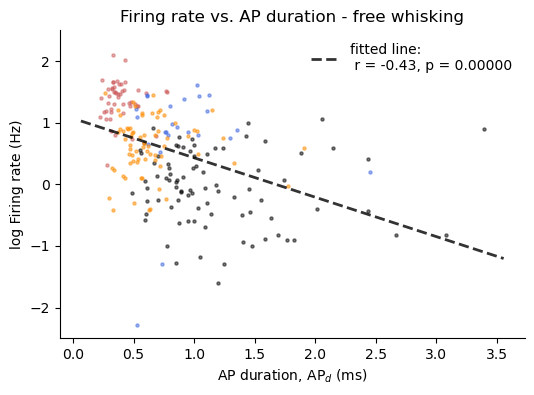

In [22]:
# Define figure
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4), dpi=100)
remove_top_right_frame(ax)

# Plot data 
for i, c_type in enumerate(cell_class_order):
    
    data_fr = np.log(result_df[result_df.cell_type==c_type]['firing_rate'].values)/np.log(10)
    data_ap_dur = result_df[result_df.cell_type==c_type]['ap_duration'].values
    
    ax.scatter(x=data_ap_dur, 
               y=data_fr,
               s=5, 
               alpha=0.5, 
               c=class_color[c_type])
# set Y limites
plt.ylim(-2.5, 2.5)
# Axes
ax.set_xlabel('AP duration, AP$_d$ (ms)')
ax.set_ylabel('log Firing rate (Hz)')
ax.set_title('Firing rate vs. AP duration - free whisking')
    
    
# Fit linear regression model and plot regression line
data_fr_all = np.log(result_df['firing_rate'].values)/np.log(10)
data_ap_dur_all = result_df['ap_duration'].values
nan_ids = np.isinf(data_fr_all) + np.isnan(data_ap_dur_all) #finding NaNs 

X=data_ap_dur_all[~nan_ids]
y=data_fr_all[~nan_ids]

model = LinearRegression().fit(X.reshape(-1, 1), #must be 2D 
                               y)
x_range = np.array(plt.xlim())
y_fit = model.intercept_ + model.coef_[0] * x_range

result = scipy.stats.linregress(X, y)

ax.plot(x_range, 
        y_fit, 
        ls='--', 
        linewidth=2,
        color='k',
        label='fitted line: \n r = {:.2f}, p = {:.5f}'.format(result.rvalue, result.pvalue), 
        alpha=0.8)
ax.legend(frameon=False)

# Save figure
fname = os.path.join(figure_path, '3_Mean_FRvsAP_Duration.png')
plt.savefig(fname=fname, dpi='figure', format='png', bbox_inches='tight')

## Mean membrane potential Vm per cell type

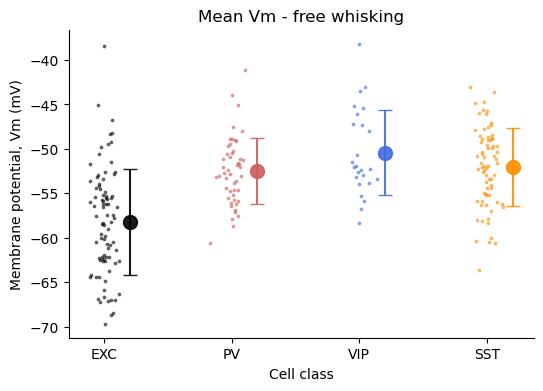

In [23]:
# Define figure
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4), dpi=100)
remove_top_right_frame(ax)

# Iterate over cell class
for i, c_type in enumerate(cell_class_order):
    
    n_cells = len(result_df[result_df.cell_type==c_type])
    obs_locations = [i]*n_cells #create a list int, to place observations categorically
    obs_values = result_df[result_df.cell_type==c_type]['mean_vm'].values * 1000 #in mV
    
    # Show individual observations (scatterplot with added x-axis jitter to avoid overplotting)
    jitter_scatterplot(x=obs_locations, 
                       y=obs_values,
                       s=3, 
                       alpha=0.5, 
                       c=class_color[c_type])
    
    # Show mean and standard deviation
    ax.errorbar(x=i+0.2,
                 y=np.nanmean(obs_values),
                 yerr=np.nanstd(obs_values), #errobarsize is standard deviation
                 marker='o', 
                 ms=10, 
                 capsize=5, 
                 alpha=0.9, 
                 c=class_color[c_type])
    
# Set xtick labels and legend
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(cell_class_order)
ax.set_xlabel('Cell class')
ax.set_ylabel('Membrane potential, Vm (mV)')
ax.set_title('Mean Vm - free whisking')
    
    
# Save figure
fname = os.path.join(figure_path, '4_Mean_Vm.png')
plt.savefig(fname=fname, dpi='figure', format='png', bbox_inches='tight')
       


In [24]:
# stats comparison between cell types (Tukey's HSD test)
from scipy.stats import tukey_hsd
Obs_EXC = result_df[result_df.cell_type=='EXC']['mean_vm'].values
Obs_PV = result_df[result_df.cell_type=='PV']['mean_vm'].values
Obs_VIP = result_df[result_df.cell_type=='VIP']['mean_vm'].values
Obs_SST = result_df[result_df.cell_type=='SST']['mean_vm'].values
    
Res=tukey_hsd(Obs_EXC, Obs_PV, Obs_VIP, Obs_SST)
print(Res)

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.006     0.000    -0.008    -0.003
 (0 - 2)     -0.008     0.000    -0.011    -0.005
 (0 - 3)     -0.006     0.000    -0.008    -0.004
 (1 - 0)      0.006     0.000     0.003     0.008
 (1 - 2)     -0.002     0.344    -0.005     0.001
 (1 - 3)     -0.000     0.959    -0.003     0.002
 (2 - 0)      0.008     0.000     0.005     0.011
 (2 - 1)      0.002     0.344    -0.001     0.005
 (2 - 3)      0.002     0.522    -0.001     0.005
 (3 - 0)      0.006     0.000     0.004     0.008
 (3 - 1)      0.000     0.959    -0.002     0.003
 (3 - 2)     -0.002     0.522    -0.005     0.001



### Mean SD of the Vm per cell type

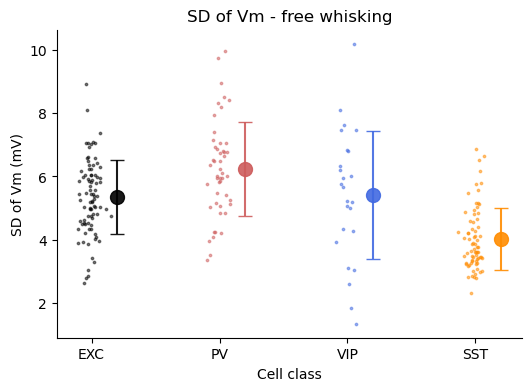

In [25]:
# Define figure
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4), dpi=100)
remove_top_right_frame(ax)

# Iterate over cell class
for i, c_type in enumerate(cell_class_order):
    
    n_cells = len(result_df[result_df.cell_type==c_type])
    obs_locations = [i]*n_cells #create a list int, to place observations categorically
    obs_values = result_df[result_df.cell_type==c_type]['std_vm'].values * 1000 #in mV
    
    # Show individual observations (scatterplot with added x-axis jitter to avoid overplotting)
    jitter_scatterplot(x=obs_locations, 
                       y=obs_values,
                       s=3, 
                       alpha=0.5, 
                       c=class_color[c_type])
    
    # Show mean and standard deviation
    ax.errorbar(x=i+0.2,
                 y=np.nanmean(obs_values),
                 yerr=np.nanstd(obs_values), #errobarsize is standard deviation
                 marker='o', 
                 ms=10, 
                 capsize=5, 
                 alpha=0.9, 
                 c=class_color[c_type])
    
# Set xtick labels and legend
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(cell_class_order)
ax.set_xlabel('Cell class')
ax.set_ylabel('SD of Vm (mV)')
ax.set_title('SD of Vm - free whisking')
    
    
# Save figure
fname = os.path.join(figure_path, '5_Mean_Vm_SD.png')
plt.savefig(fname=fname, dpi='figure', format='png', bbox_inches='tight')
       


In [26]:
# stats comparison between cell types (Tukey's HSD test)
from scipy.stats import tukey_hsd
Obs_EXC = result_df[result_df.cell_type=='EXC']['std_vm'].values
Obs_PV = result_df[result_df.cell_type=='PV']['std_vm'].values
Obs_VIP = result_df[result_df.cell_type=='VIP']['std_vm'].values
Obs_SST = result_df[result_df.cell_type=='SST']['std_vm'].values
    
Res=tukey_hsd(Obs_EXC, Obs_PV, Obs_VIP, Obs_SST)
print(Res)

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.001     0.001    -0.002    -0.000
 (0 - 2)     -0.000     0.995    -0.001     0.001
 (0 - 3)      0.001     0.000     0.001     0.002
 (1 - 0)      0.001     0.001     0.000     0.002
 (1 - 2)      0.001     0.058    -0.000     0.002
 (1 - 3)      0.002     0.000     0.002     0.003
 (2 - 0)      0.000     0.995    -0.001     0.001
 (2 - 1)     -0.001     0.058    -0.002     0.000
 (2 - 3)      0.001     0.000     0.001     0.002
 (3 - 0)     -0.001     0.000    -0.002    -0.001
 (3 - 1)     -0.002     0.000    -0.003    -0.002
 (3 - 2)     -0.001     0.000    -0.002    -0.001



## Mean FFT per cell type

To plot the mean FFT per cell type, remember we stored these mean FFT, per cell, in the variable `result_fft_cell_type`.

In [27]:
from utils import plot_avg_mean_fft

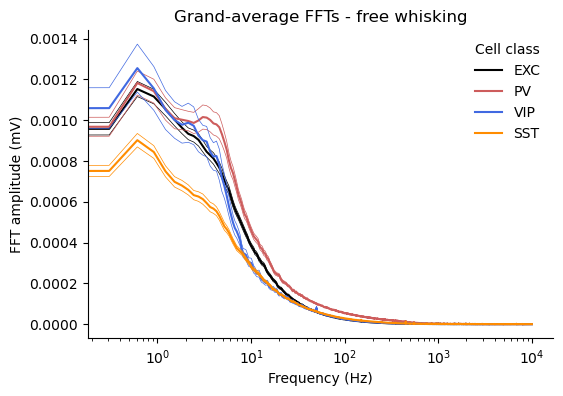

In [28]:
# Define figure
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4), dpi=100)
remove_top_right_frame(ax)

# Iterate over cell class
for i, c_type in enumerate(cell_class_order):
    
    #Provide as input a matrix (stacked average FFTs)
    fft_matrix = np.stack(result_fft_cell_type[c_type], axis=1)
    plot_avg_mean_fft(ax, fft_matrix, sr_vm, c_type, class_color[c_type])

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('FFT amplitude (mV)')
ax.set_title('Grand-average FFTs - free whisking')
ax.legend(frameon=False, loc='upper right', title='Cell class')

# Save figure
fname = os.path.join(figure_path, '6_GRD_AVG_FFTs.png')
plt.savefig(fname=fname, dpi='figure', format='png', bbox_inches='tight')


## Mean FFT amplitude, low frequencies, per cell type

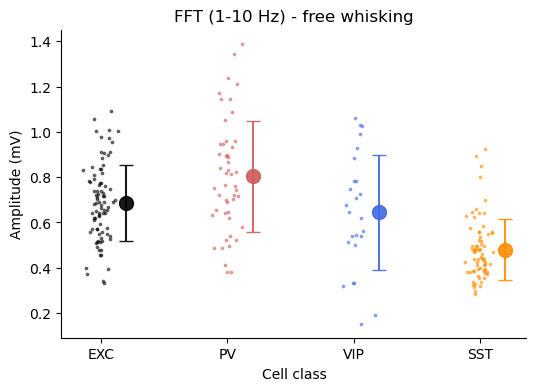

In [29]:
# Define figure
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4), dpi=100)
remove_top_right_frame(ax)

# Iterate over cell class
for i, c_type in enumerate(cell_class_order):
    
    n_cells = len(result_df[result_df.cell_type==c_type])
    obs_locations = [i]*n_cells #create a list int, to place observations categorically
    obs_values = result_df[result_df.cell_type==c_type]['fft_low'].values * 1000 #in mV
    
    # Show individual observations (scatterplot with added x-axis jitter to avoid overplotting)
    jitter_scatterplot(x=obs_locations, 
                       y=obs_values,
                       s=3, 
                       alpha=0.5, 
                       c=class_color[c_type])
    
    # Show mean and standard deviation
    ax.errorbar(x=i+0.2,
                 y=np.nanmean(obs_values),
                 yerr=np.nanstd(obs_values), #errobarsize is standard deviation
                 marker='o', 
                 ms=10, 
                 capsize=5, 
                 alpha=0.9, 
                 c=class_color[c_type])
    
# Set xtick labels and legend
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(cell_class_order)
ax.set_xlabel('Cell class')
ax.set_ylabel('Amplitude (mV)')
ax.set_title('FFT (1-10 Hz) - free whisking')
    
    
# Save figure
fname = os.path.join(figure_path, '7_Mean_FFT_LF.png')
plt.savefig(fname=fname, dpi='figure', format='png', bbox_inches='tight')
       


In [30]:
# stats comparison between cell types (Tukey's HSD test)
from scipy.stats import tukey_hsd
Obs_EXC = result_df[result_df.cell_type=='EXC']['fft_low'].values
Obs_PV = result_df[result_df.cell_type=='PV']['fft_low'].values
Obs_VIP = result_df[result_df.cell_type=='VIP']['fft_low'].values
Obs_SST = result_df[result_df.cell_type=='SST']['fft_low'].values
    
Res=tukey_hsd(Obs_EXC, Obs_PV, Obs_VIP, Obs_SST)
print(Res)

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.000     0.004    -0.000    -0.000
 (0 - 2)      0.000     0.774    -0.000     0.000
 (0 - 3)      0.000     0.000     0.000     0.000
 (1 - 0)      0.000     0.004     0.000     0.000
 (1 - 2)      0.000     0.005     0.000     0.000
 (1 - 3)      0.000     0.000     0.000     0.000
 (2 - 0)     -0.000     0.774    -0.000     0.000
 (2 - 1)     -0.000     0.005    -0.000    -0.000
 (2 - 3)      0.000     0.001     0.000     0.000
 (3 - 0)     -0.000     0.000    -0.000    -0.000
 (3 - 1)     -0.000     0.000    -0.000    -0.000
 (3 - 2)     -0.000     0.001    -0.000    -0.000



## Correlation between Firing rate and AP threshold, Vm SD and mean Vm

/tmp/ipykernel_40995/3635722927.py:8: RuntimeWarning: divide by zero encountered in log
  data_fr = np.log(result_df[result_df.cell_type==c_type]['firing_rate'].values)/np.log(10)
/tmp/ipykernel_40995/3635722927.py:25: RuntimeWarning: divide by zero encountered in log
  data_fr_all = np.log(result_df['firing_rate'].values)/np.log(10)


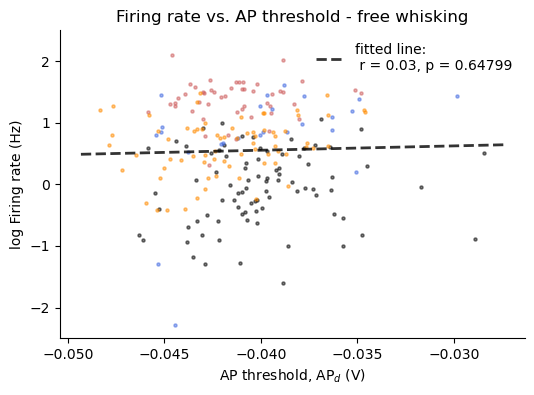

In [31]:
# Define figure
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4), dpi=100)
remove_top_right_frame(ax)

# Plot data 
for i, c_type in enumerate(cell_class_order):
    
    data_fr = np.log(result_df[result_df.cell_type==c_type]['firing_rate'].values)/np.log(10)
    data_ap_thrs = result_df[result_df.cell_type==c_type]['ap_threshold'].values
    
    ax.scatter(x=data_ap_thrs, 
               y=data_fr,
               s=5, 
               alpha=0.5, 
               c=class_color[c_type])
# set Y limites
plt.ylim(-2.5, 2.5)
# Axes
ax.set_xlabel('AP threshold, AP$_d$ (V)')
ax.set_ylabel('log Firing rate (Hz)')
ax.set_title('Firing rate vs. AP threshold - free whisking')
    
    
# Fit linear regression model and plot regression line
data_fr_all = np.log(result_df['firing_rate'].values)/np.log(10)
data_ap_thrs_all = result_df['ap_threshold'].values
nan_ids = np.isinf(data_fr_all) + np.isnan(data_ap_thrs_all) #finding NaNs 
X=data_ap_thrs_all[~nan_ids]
y=data_fr_all[~nan_ids]
#
model = LinearRegression().fit(X.reshape(-1, 1), #must be 2D 
                               y)
x_range = np.array(plt.xlim())
y_fit = model.intercept_ + model.coef_[0] * x_range

result = scipy.stats.linregress(X, y)

ax.plot(x_range, 
        y_fit, 
        ls='--', 
        linewidth=2,
        color='k',
        label='fitted line: \n r = {:.2f}, p = {:.5f}'.format(result.rvalue, result.pvalue),
        alpha=0.8)
ax.legend(frameon=False)

# Save figure
fname = os.path.join(figure_path, '8_Mean_FR_Correlations_APthreshold.png')
plt.savefig(fname=fname, dpi='figure', format='png', bbox_inches='tight')

/tmp/ipykernel_40995/1463483675.py:8: RuntimeWarning: divide by zero encountered in log
  data_fr = np.log(result_df[result_df.cell_type==c_type]['firing_rate'].values)/np.log(10)
/tmp/ipykernel_40995/1463483675.py:25: RuntimeWarning: divide by zero encountered in log
  data_fr_all = np.log(result_df['firing_rate'].values)/np.log(10)


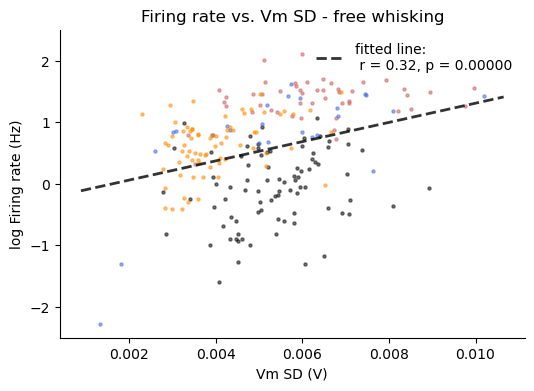

In [32]:
# Define figure
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4), dpi=100)
remove_top_right_frame(ax)

# Plot data 
for i, c_type in enumerate(cell_class_order):
    
    data_fr = np.log(result_df[result_df.cell_type==c_type]['firing_rate'].values)/np.log(10)
    data_std_vm = result_df[result_df.cell_type==c_type]['std_vm'].values
    
    ax.scatter(x=data_std_vm, 
               y=data_fr,
               s=5, 
               alpha=0.5, 
               c=class_color[c_type])
# set Y limites
plt.ylim(-2.5, 2.5)
# Axes
ax.set_xlabel('Vm SD (V)')
ax.set_ylabel('log Firing rate (Hz)')
ax.set_title('Firing rate vs. Vm SD - free whisking')
    
    
# Fit linear regression model and plot regression line
data_fr_all = np.log(result_df['firing_rate'].values)/np.log(10)
data_std_vm_all = result_df['std_vm'].values
nan_ids = np.isinf(data_fr_all) + np.isnan(data_ap_thrs_all) #finding NaNs 
X=data_std_vm_all[~nan_ids]
y=data_fr_all[~nan_ids]
#
model = LinearRegression().fit(X.reshape(-1, 1), #must be 2D 
                               y)
x_range = np.array(plt.xlim())
y_fit = model.intercept_ + model.coef_[0] * x_range

result = scipy.stats.linregress(X, y)

ax.plot(x_range, 
        y_fit, 
        ls='--', 
        linewidth=2,
        color='k',
        label='fitted line: \n r = {:.2f}, p = {:.5f}'.format(result.rvalue, result.pvalue), 
        alpha=0.8)
ax.legend(frameon=False)

# Save figure
fname = os.path.join(figure_path, '8_Mean_FR_Correlations_VmSD.png')
plt.savefig(fname=fname, dpi='figure', format='png', bbox_inches='tight')

/tmp/ipykernel_40995/2842138433.py:8: RuntimeWarning: divide by zero encountered in log
  data_fr = np.log(result_df[result_df.cell_type==c_type]['firing_rate'].values)/np.log(10)
/tmp/ipykernel_40995/2842138433.py:25: RuntimeWarning: divide by zero encountered in log
  data_fr_all = np.log(result_df['firing_rate'].values)/np.log(10)


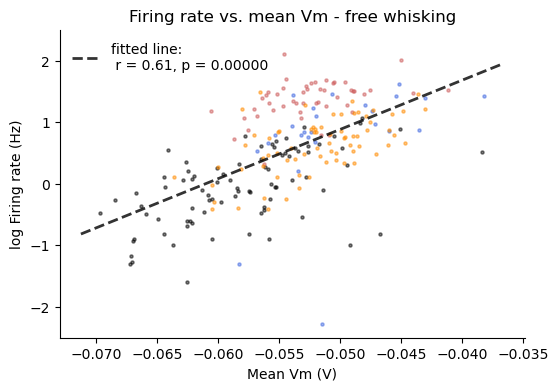

In [33]:
# Define figure
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4), dpi=100)
remove_top_right_frame(ax)

# Plot data 
for i, c_type in enumerate(cell_class_order):
    
    data_fr = np.log(result_df[result_df.cell_type==c_type]['firing_rate'].values)/np.log(10)
    data_mean_vm = result_df[result_df.cell_type==c_type]['mean_vm'].values
    
    ax.scatter(x=data_mean_vm, 
               y=data_fr,
               s=5, 
               alpha=0.5, 
               c=class_color[c_type])
# set Y limites
plt.ylim(-2.5, 2.5)
# Axes
ax.set_xlabel('Mean Vm (V)')
ax.set_ylabel('log Firing rate (Hz)')
ax.set_title('Firing rate vs. mean Vm - free whisking')
    
    
# Fit linear regression model and plot regression line
data_fr_all = np.log(result_df['firing_rate'].values)/np.log(10)
data_mean_vm_all = result_df['mean_vm'].values
nan_ids = np.isinf(data_fr_all) + np.isnan(data_ap_thrs_all) #finding NaNs 
X=data_mean_vm_all[~nan_ids]
y=data_fr_all[~nan_ids]
#
model = LinearRegression().fit(X.reshape(-1, 1),y)
x_range = np.array(plt.xlim())
y_fit = model.intercept_ + model.coef_[0] * x_range


result = scipy.stats.linregress(X, y)

ax.plot(x_range, 
        y_fit, 
        ls='--', 
        linewidth=2,
        color='k',
        label='fitted line: \n r = {:.2f}, p = {:.5f}'.format(result.rvalue, result.pvalue), 
        alpha=0.8)
ax.legend(frameon=False)

# Save figure
fname = os.path.join(figure_path, '8_Mean_FR_Correlations_meanVm.png')
plt.savefig(fname=fname, dpi='figure', format='png', bbox_inches='tight')

**End of notebook**.